# **Twitter Sentiment Analysis**

- Analysing People's Mindset during recent International Issue and modelling thier views on it.

## Set Tweet File Name Constants
Doing so allows the Notebook to be copied, the date set and the following "pipeline" will work.

## Import Libraries
For this analysis, I'll import the usual suspects: Pandas, Seaborn, Matplotlib's PyPlot, Natural Language Toolkit (NLTK), and its corpus of stop-words. To present findings, I'll import Wordcloud. Beautiful Soup and unicodedata are great at transforming HTML and Unicode data to ASCII.

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from wordcloud import WordCloud, ImageColorGenerator
import re
import string
from bs4 import BeautifulSoup
import unicodedata
import warnings

## Set Stopwords 
Stop words add little context to natural language processing. Create a set of unique stop words.

In [66]:
stopword=set(stopwords.words('english')) # stopwords don't add much context

## Suppress Beautiful Soup Warnings
Locator warnings are irrelevant to the task at hand. Let's suppress that warning. Frankly, I don't care if something looks like a file name or URL in this context.

In [67]:
warnings.filterwarnings("ignore")

## Create work methods for work
Create methods to pipeline data cleansing,transformation, and other scut work.

### Create a method to strip emoji
Credit: Thank you Denis da Mata for this effective Regular Expression method on [Stack Overflow Removing Emojis from string in Python](https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python). This method will remove most if not all emojies from text.

In [68]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

### Create methods for horizontal bar charting
Ensure dataframe's x is always called total. 

In [69]:
def draw_bar_chart(data, title, ylabel):
    sns.set_theme(style='whitegrid')
    fig, ax = plt.subplots(figsize=(12,7))
    sns.barplot(y=data.index.values, x='total', data=data, orient='h',color=XKCD_COLOR)
    ax.set_yticklabels([label[0] for label in data.index.values])
    ax.set(xlabel='Count', ylabel=ylabel)
    fig.suptitle(title, fontsize=22, fontweight='bold')

def draw_language_chart(data):
    sns.set_theme(style='whitegrid')
    fig, ax = plt.subplots(figsize=(12,7))
    sns.barplot(data=data[:10], y='language', x='total', orient='h', color=XKCD_COLOR)
    ax.set(xlabel='Count', ylabel='Language')
    fig.suptitle('10 Most Common Languages in Tweets', fontsize=22, fontweight='bold')
    
def draw_user_chart(data):
    sns.set_theme(style='whitegrid')
    fig, ax = plt.subplots(figsize=(12,7))
    sns.barplot(data=data, y='username', x='total', orient='h', color=XKCD_COLOR)
    ax.set(xlabel='Count', ylabel='User Name')
    fig.suptitle('20 Most Common User Names', fontsize=22, fontweight='bold')

### Create a method to extract to a list
For Tweet addressee and hashtags, need to extract data to a list efficiently.

In [70]:
def extract_to_list(d,fld):
    list_to_return = []
    for i in d[fld]:
        if len(i) !=0:
            for j in i:
                list_to_return.append(j.lower())
    return list_to_return

### Create a method for final cleaning before generating a word cloud
Terms like, 'Russia' and 'Ukraine' and their pronouns/adjectives aren't meaningful really. Removing them and the term ' s ' provides more meaningful text.

In [71]:
def scrub_tweet(text):
    text = re.sub('russian?|ukrain[e|ian]?', '', text)
    text = re.sub(' s ', ' ', text) # tweets sometimes get left with single 's' as word; strip it; it's meaningless to the analysis
    while '  ' in text:
        text = text.replace('  ',' ')
    return text

### Create a Tweet cleaning method
Method to clean up and prepare the data for inclusion in a word cloud.

In [72]:
def clean_tweet(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode() # convert unicode to ascii where possible
    text = str(text).lower() # lowercase the text
    text = ' '.join([word for word in text.split() if not word.startswith('@')]) # get rid of usernames
    text = ' '.join([word for word in text.split() if not word.startswith('#')]) # get rid of hashtags
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove urls
    text = BeautifulSoup(text, 'html.parser').string # parse any html and return it as a string
    if text is None:
        return ''
    text = re.sub('\[.*?\]', '', text)
    text = remove_emojis(text) # get rid of emojis
    text = re.sub('\n', '', text) # drop all line feeds
    text = re.sub('\w*\d\w*', '', text) # bye digits in words
    text = ' '.join([word for word in text.split(' ') if word not in stopword])
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = ' '.join([word for word in text.split(' ') if len(word) > 3 ])
    while text.find('  ') != -1:
        text = re.sub('\s\s', ' ', text) # strip double spaces
    return text.strip()

### Create a method to generate consistent word clouds
In the last analyses, word clouds used a maximum of 200 words, then 100. That produced a far too cluttered graphic. This word cloud will use 50 words instead.

In [73]:
def generate_wordcloud(text, group='All'):
    # stop words were already stripped; no need to do it here
    MAXIMUM_WORDS = 50
    CHART_TITLE = '{} Most Common Words in {} Sentiment Tweets'.format(MAXIMUM_WORDS, group)
    fig, ax = plt.subplots(figsize=(12,7))
    wordcloud = WordCloud(background_color="black", colormap='hsv', collocations=False,
                          max_words=MAXIMUM_WORDS, random_state=RANDOM_STATE).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
    plt.axis('off')
    fig.suptitle(CHART_TITLE, fontsize=22, fontweight='bold')
    plt.show()

### Create a method to generate a collocation word cloud
Collocations determine phrases that often appear together. For example, 'collateral damage' is a bigram phrase that appears often together. 

In [74]:
def generate_bigram_wordcloud(text, group='All'):
    # stop words were already stripped; no need to do it here
    MAXIMUM_PHRASES = 20
    FREQUENCY = 4
    CHART_TITLE = '{} Most Common Bigram Terms in {} Sentiment Tweets'.format(MAXIMUM_PHRASES, group)
    fig, ax = plt.subplots(figsize=(12,7))
    wordcloud = WordCloud(background_color="black", colormap='hsv', collocations=True,
                          max_words=MAXIMUM_PHRASES, random_state=47, collocation_threshold=FREQUENCY).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
    plt.axis('off')
    fig.suptitle(CHART_TITLE, fontsize=22, fontweight='bold')
    plt.show()

### Create classification method for sentiment
If the compound score is within a particular range, ***classify_sentiment*** score the Tweet as 'Positive' or 'Negative' in tone. 'Neutral' is the default.

In [75]:
def classify_sentiment(row):
    classify = 'Neutral'
    if row['Compound'] >= 0.05:
        classify = 'Positive'
    elif row['Compound'] <= -0.05:
        classify = 'Negative'
    return classify

## Read Tweet Data From File
Let's take a quick gander at what's available and how it's put together.

In [76]:
data = pd.read_csv('tweets.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               10003 non-null  int64  
 1   conversation_id  10003 non-null  int64  
 2   created_at       10003 non-null  object 
 3   date             10003 non-null  object 
 4   time             10003 non-null  object 
 5   timezone         10003 non-null  int64  
 6   user_id          10003 non-null  int64  
 7   username         10003 non-null  object 
 8   name             10003 non-null  object 
 9   place            1 non-null      object 
 10  tweet            10003 non-null  object 
 11  language         10003 non-null  object 
 12  mentions         10003 non-null  object 
 13  urls             10003 non-null  object 
 14  photos           10003 non-null  object 
 15  replies_count    10003 non-null  int64  
 16  retweets_count   10003 non-null  int64  
 17  likes_count 

In [77]:
data.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1581458719845781504,1581407763250311168,2022-10-16 01:35:15 UTC,2022-10-16,01:35:15,0,1577805690185342976,lace891,Lace89,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'AaronParnas', 'name': 'Aaron...",NaN,NaN,NaN,NaN
1,1581458717585068034,1581458717585068034,2022-10-16 01:35:15 UTC,2022-10-16,01:35:15,0,3195763956,latinos4bernie,Our Revolución,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1581458717194665985,1581382234841370630,2022-10-16 01:35:14 UTC,2022-10-16,01:35:14,0,2251978568,dennisp220,"Freedom Loving ULTRA MAGA,🇺🇸🌴🦩🐊🐬🏖 🩴🦈😎✝️",NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'johnstone_tin', 'name': 'Tom...",NaN,NaN,NaN,NaN
3,1581458708877684736,1581259880928710656,2022-10-16 01:35:12 UTC,2022-10-16,01:35:12,0,1502425378001850370,jstarbux,Jon Starbux,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'MissFlyByNight', 'name': '🌛 ...",NaN,NaN,NaN,NaN
4,1581458704422928384,1581431262476005377,2022-10-16 01:35:11 UTC,2022-10-16,01:35:11,0,1195425713182015488,micahbabcock4,Micah Babcock,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Terri80501', 'name': 'sleepl...",NaN,NaN,NaN,NaN


In [78]:
data['created_at'] = pd.to_datetime(data['created_at'])

### Tweet Data Date-Time Range

In [79]:
data['created_at'].min(),data['created_at'].max()

(Timestamp('2022-10-15 23:03:07+0000', tz='UTC'),
 Timestamp('2022-10-16 01:35:15+0000', tz='UTC'))

## Exploration
It appears three useful fields for sentiment analysis are needed. They are the Tweet itself, the username, and the language the tweet was written in. The isnull().sum() tells us what fields contain sparse data and no data. Those that are null can be dropped.

In [80]:
df = data[['username', 'created_at','tweet','language']]

In [81]:
df.isnull().sum()

username      0
created_at    0
tweet         0
language      0
dtype: int64

In [82]:
df.dropna(inplace=True) # dump those nulls if there are any

In [83]:
df.head()

,username,created_at,tweet,language
0,lace891,2022-10-16 01:35:15+00:00,@AaronParnas The most corrupt country in all o...,en
1,latinos4bernie,2022-10-16 01:35:15+00:00,"Russia is kidnapping, trafficking Ukrainian ch...",en
2,dennisp220,2022-10-16 01:35:14+00:00,"@johnstone_tin @JonathanTurley No, the FBI age...",en
3,jstarbux,2022-10-16 01:35:12+00:00,@MissFlyByNight Russia left overs.,nl
4,micahbabcock4,2022-10-16 01:35:11+00:00,@Terri80501 @JimIgnatowski5 @JohnFetterman Dem...,en


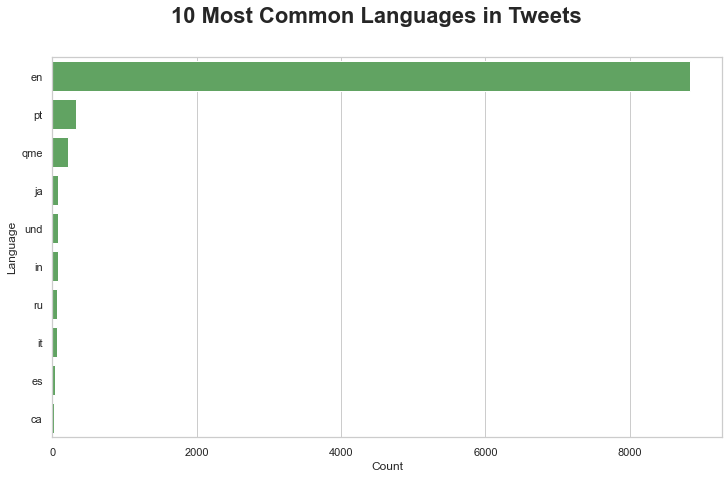

In [84]:
language_df = pd.DataFrame(df['language'].value_counts().reset_index().values, columns=['language', 'total'])
draw_language_chart(language_df)

### Language Analysis
By far, most of the tweets are in English. We'll filter to those only.

In [85]:
df = df.query('language == "en" or language == "uk"') # English language Tweets comprise greatest dataset

In [86]:
df['language'].value_counts() # confirm only English-language Tweets remain.

en    8833
uk       7
Name: language, dtype: int64

### Who's Prolific?

In [87]:
df_usernames = data['username'].value_counts()[:20].to_frame(name='total').reset_index()
df_usernames.columns = ['username','total']
df_usernames

,username,total
0,ayamira26246264,23
1,russiaconflict,21
2,tyrell_corpnafo,21
3,geromanrt,21
4,arturo_arian,18
5,myafendi,16
6,anarussia18,16
7,ohsabiofficial,15
8,freerussia12,15
9,kostiuk_martha,13


## Top 20 Tweet Addressees
Let's grab the dataset's @ addressees and graph the top 20 used.

In [88]:
data['addressee'] = data['tweet'].apply(lambda addressee: re.findall(r'\@\w+', addressee))

In [89]:
data['addressee'].head(10) # check the regex worked

0                                    [@AaronParnas]
1                                                []
2                 [@johnstone_tin, @JonathanTurley]
3                                 [@MissFlyByNight]
4    [@Terri80501, @JimIgnatowski5, @JohnFetterman]
5                                                []
6                                       [@have_odd]
7                          [@AdeldMeyer, @elonmusk]
8                                                []
9                                    [@russia_urdu]
Name: addressee, dtype: object

### Extract Addressees To List

In [90]:
addressee_list = extract_to_list(data,'addressee')
addressee_list[:5]

['@aaronparnas',
 '@johnstone_tin',
 '@jonathanturley',
 '@missflybynight',
 '@terri80501']

In [91]:
print('Total Addressees: {}'.format(len(addressee_list)))
print('Unique Addressees: {}'.format(len(set(addressee_list))))

Total Addressees: 23469
Unique Addressees: 6408


In [92]:
df_addressees = pd.DataFrame(data=addressee_list, columns=['addressee'])

### Chart the Most Frequent Tweeters
This chart is the odd one out as the information in the index doesn't require extraction from a tuple.

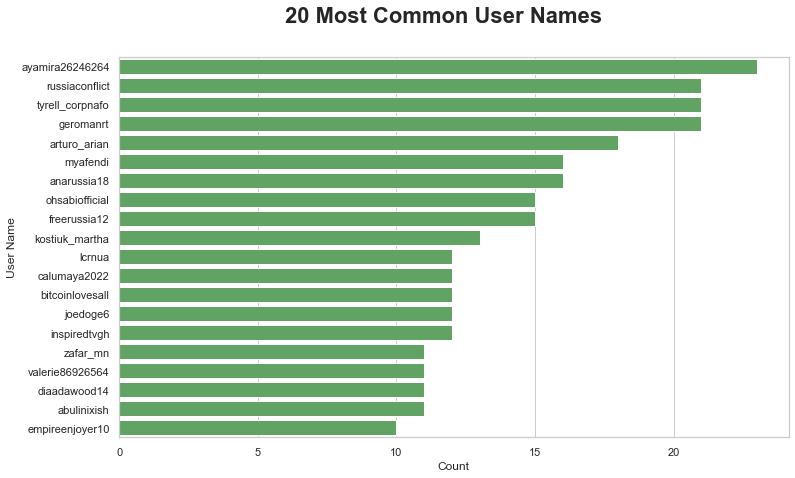

In [93]:
draw_user_chart(df_usernames)

## Chart the Most Frequent Addressees

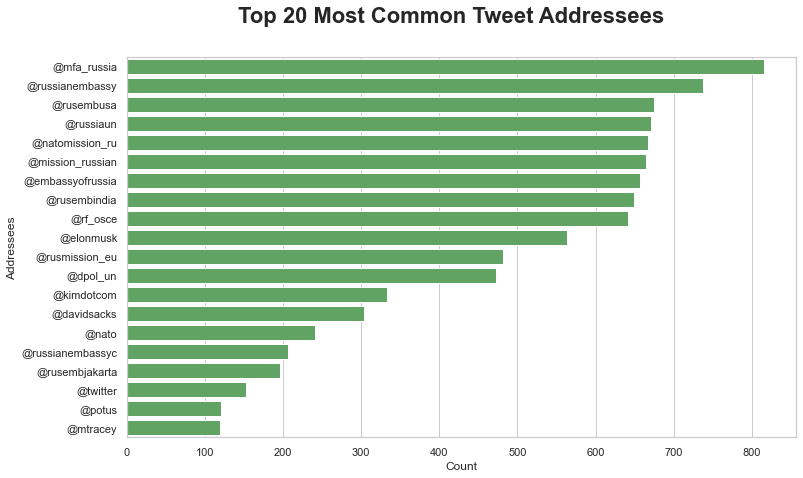

In [94]:
df_addressees_2 = df_addressees.value_counts()[:20].to_frame(name='total')
draw_bar_chart(data=df_addressees_2, title='Top 20 Most Common Tweet Addressees', ylabel='Addressees')

### What are the addressee frequencies?

In [95]:
print(df_addressees_2)

                  total
addressee              
@mfa_russia         816
@russianembassy     737
@rusembusa          675
@russiaun           671
@natomission_ru     667
@mission_russian    664
@embassyofrussia    657
@rusembindia        649
@rf_osce            641
@elonmusk           564
@rusmission_eu      482
@dpol_un            472
@kimdotcom          333
@davidsacks         304
@nato               241
@russianembassyc    206
@rusembjakarta      196
@twitter            153
@potus              121
@mtracey            120


The #1 addressee for tweets is the **Russian Ministry of Foreign Affairs** followed by Ukraine's English-language news service **Kyiv Independent**. In third place is the Twitter **English** account for the **Kremlin**.

## Top 20 Hashtags
Let's take a look at the top 20 hashtags that appear in Tweets.

In [96]:
data['hashtag'] = data['tweet'].apply(lambda hashtag: re.findall(r'\#\w+', hashtag))
data['hashtag'].head(10) # check the regex worked

0                                                   []
1                                 [#UkrainianGenocide]
2                                                   []
3                                                   []
4                                                   []
5    [#Russia, #Ukraine, #Britain, #America, #tuesd...
6                                                   []
7                                                   []
8    [#How, #Putin, #Dissension, #ranks, #NATO, #hi...
9                                                   []
Name: hashtag, dtype: object

In [97]:
hashtag_list = extract_to_list(data,'hashtag')
hashtag_list[:10]

['#ukrainiangenocide',
 '#russia',
 '#ukraine',
 '#britain',
 '#america',
 '#tuesdayvibe',
 '#how',
 '#putin',
 '#dissension',
 '#ranks']

In [98]:
print('Total Hashtags: {}'.format(len(hashtag_list)))
print('Unique Hashtags: {}'.format(len(set(hashtag_list))))

Total Hashtags: 3772
Unique Hashtags: 1282


In [99]:
df_hashtags = pd.DataFrame(data=hashtag_list, columns=['hashtag'])

## Chart The 20 Most Frequent Hashtags

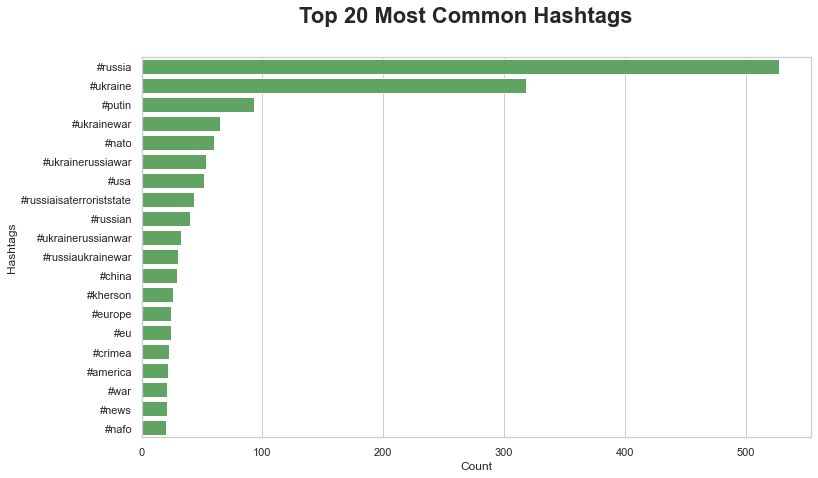

In [100]:
df_hashtags_2 = df_hashtags.value_counts()[:20].to_frame(name='total')
draw_bar_chart(data=df_hashtags_2, title='Top 20 Most Common Hashtags', ylabel='Hashtags')

### Hashtag Counts

In [101]:
print(df_hashtags_2)

                          total
hashtag                        
#russia                     528
#ukraine                    318
#putin                       93
#ukrainewar                  65
#nato                        60
#ukrainerussiawar            53
#usa                         52
#russiaisaterroriststate     43
#russian                     40
#ukrainerussianwar           33
#russiaukrainewar            30
#china                       29
#kherson                     26
#europe                      24
#eu                          24
#crimea                      23
#america                     22
#war                         21
#news                        21
#nafo                        20


## Clean & Stem The Tweets

In [102]:
df['tweet'].iloc[47] # pre-cleaned tweet

'@joncoopertweets Russia Russia Russia, Jan 6, Jan 6 Jan 6, The Dossier. LOL your so original Jon'

In [103]:
df['tweet'] = df['tweet'].apply(clean_tweet)

In [104]:
df['tweet'].iloc[47] # tweet after cleaning

'russia russia russia dossier original'

## Score the Tweets

In [105]:
sentiments = SentimentIntensityAnalyzer()

df['Positive'] = [sentiments.polarity_scores(i)['pos'] for i in df['tweet']]
df['Neutral'] = [sentiments.polarity_scores(i)['neu'] for i in df['tweet']]
df['Negative'] = [sentiments.polarity_scores(i)['neg'] for i in df['tweet']]
df['Compound'] = [sentiments.polarity_scores(i)['compound'] for i in df['tweet']]

In [106]:
print(df['tweet'].iloc[47],'\n',df['Compound'].iloc[47])

russia russia russia dossier original 
 0.3182


In [107]:
df[['tweet','Positive','Neutral','Negative', 'Compound']].head(10)
# let's look at the positive, neutral, and negative language scores for the tweet; each tweet is a mix of all three really.

,tweet,Positive,Neutral,Negative,Compound
0,corrupt country europe giving little piece shi...,0.091,0.570,0.339,-0.7595
1,russia kidnapping trafficking ukrainian childr...,0.000,1.000,0.000,0.0000
2,agents failed russia hoax bribery perjured fis...,0.074,0.426,0.500,-0.9001
4,democrats brought open borders recession skyro...,0.000,0.562,0.437,-0.9325
5,horrific counterattack ukrainian drones drop b...,0.000,0.444,0.556,-0.8750
6,thats comes populism foreign policy isolationi...,0.097,0.903,0.000,0.1027
7,communication paramount defense country mounte...,0.145,0.705,0.150,-0.2732
8,birds stone wedges zelensky,0.000,1.000,0.000,0.0000
10,also came expense world wars takes world germa...,0.149,0.557,0.294,-0.6908
11,since want peace whole point coup anri russia ...,0.128,0.481,0.390,-0.8957


## Sentiment Score Results

In [108]:
df[['Positive','Neutral','Negative','Compound']].sum()

Positive    1240.9210
Neutral     6034.3870
Negative    1542.7030
Compound    -680.1385
dtype: float64

Overall, as a whole, the sentiment of the Tweets are negative. This is expected given the state of affairs with Russia.

In [109]:
pos = df['Positive'].sum()
neg = df['Negative'].sum()
neu = df['Neutral'].sum()
print('Ratio of Negative to Positive Tweet Score Sums: {:.0f}:{:.0f} ({:.2f}:1)'.format(neg, pos, neg / pos))

Ratio of Negative to Positive Tweet Score Sums: 1543:1241 (1.24:1)


### Classify Sentiment

In [110]:
df['Sentiment'] = df.apply(classify_sentiment, axis=1)

In [111]:
pos = df['Sentiment'][df['Sentiment'] == 'Positive'].count()
neg = df['Sentiment'][df['Sentiment'] == 'Negative'].count()
neu = df['Sentiment'][df['Sentiment'] == 'Neutral'].count()
df['Sentiment'].value_counts()

Negative    3966
Positive    3002
Neutral     1872
Name: Sentiment, dtype: int64

If viewed by simple sentiment, the bulk are Negative in tone. It shows a clear and definite pattern of negative sentiment to positive.

In [112]:
print('Ratio of Negative to Positive Tweets by Sentiment Count: {:.0f}:{:.0f} ({:.2f}:1)'.format(neg, pos, neg / pos))

Ratio of Negative to Positive Tweets by Sentiment Count: 3966:3002 (1.32:1)


## Create Strings for Word Clouds

In [113]:
all_tweets = scrub_tweet(' '.join(i for i in df['tweet']).strip())
positive_tweets = scrub_tweet(' '.join([i for i in df['tweet'][df['Sentiment'] == 'Positive']]).strip())
negative_tweets = scrub_tweet(' '.join([i for i in df['tweet'][df['Sentiment'] == 'Negative']]).strip())
neutral_tweets = scrub_tweet(' '.join([i for i in df['tweet'][df['Sentiment'] == 'Neutral']]).strip())

## Word Clouds

### All Tweet Text Word Cloud

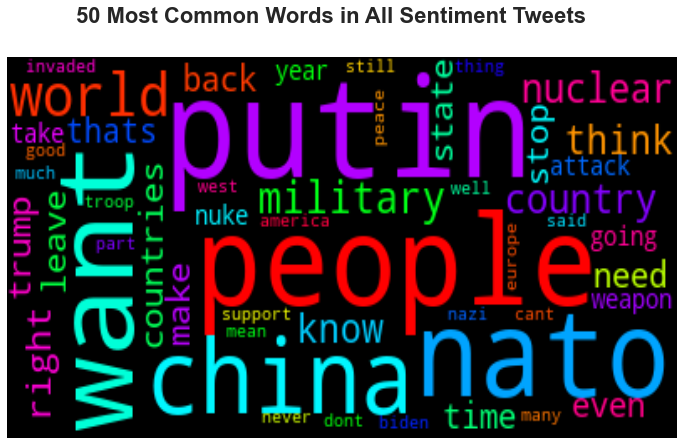

In [114]:
generate_wordcloud(all_tweets)

### Positive Sentiment Tweets Word Cloud

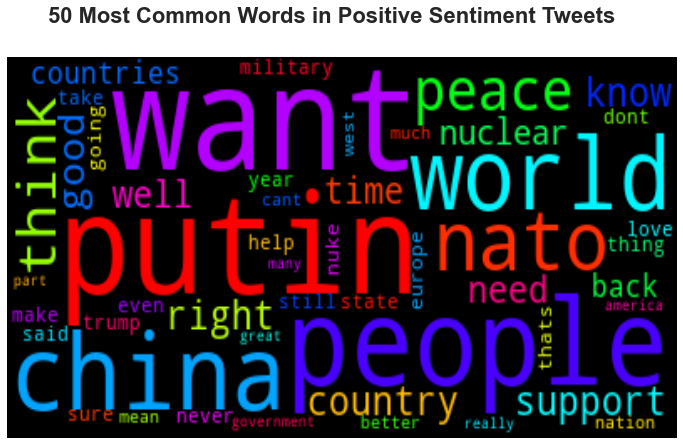

In [115]:
generate_wordcloud(positive_tweets, 'Positive')

### Negative Sentiment Tweets Word Cloud

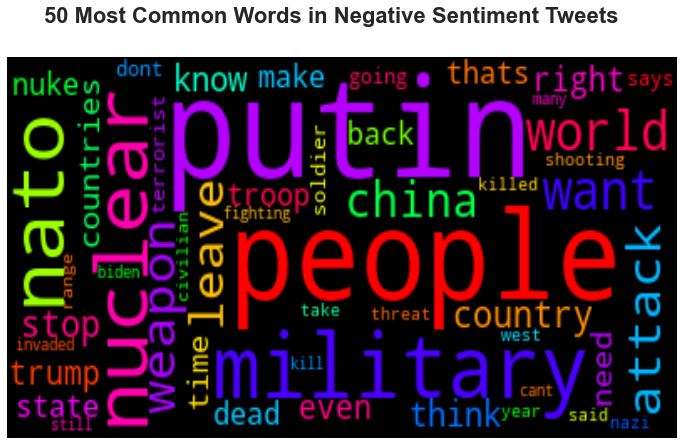

In [116]:
generate_wordcloud(negative_tweets, 'Negative')

### Neutral Sentiment Tweets Word Cloud

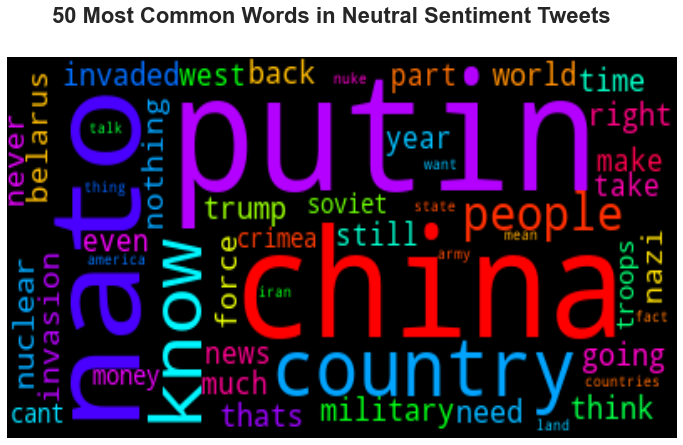

In [117]:
generate_wordcloud(neutral_tweets, 'Neutral')

### Common Bigrams in Negative Tweets
Common collocated bigram terms appearing in Negative Sentiment Tweets.

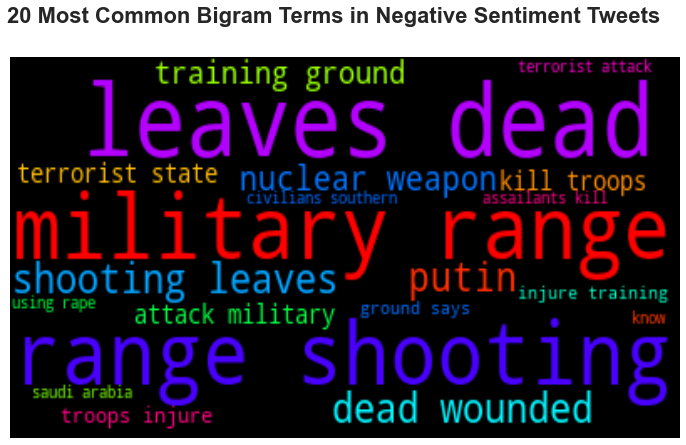

In [118]:
generate_bigram_wordcloud(negative_tweets, 'Negative')

# **Summary**
There are a lot of tweets about the Ukraine and Russia war where people tend to update about the ground truths, what they feel about it, and who they are supporting. I used those tweets for the task of Twitter sentiment analysis on the Ukraine and Russia war.